In [1]:
import numpy as np
import scipy.io.wavfile
import matplotlib.pyplot as plt
import bisect
import pandas as pd

from astromusic import spectrum

In [2]:
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.figsize'] = [10,5]

# Importing wave data

In [3]:
SAMPLE_WIDTH = 2
sample_root = 'c:/data/music'
c_fname = f'{sample_root}/c.wav'
c_freq = 261.6256

### Using scipy

In [4]:
sample_rate, audio_data = scipy.io.wavfile.read(c_fname)
channels = 1 if len(audio_data.shape)==1 else audio_data.shape[1]
sz = len(audio_data)
duration = sz / sample_rate
print(c_fname)
print('channels:', channels)
print('sample rate:', sample_rate, 'Hz')
print('duration:', duration)

c:/data/music/c.wav
channels: 2
sample rate: 44100 Hz
duration: 2.25


### Using simpleaudio

In [5]:
import simpleaudio as sa

wave_obj =  sa.WaveObject.from_wave_file(c_fname)
sa_data = np.frombuffer(wave_obj.audio_data, dtype=np.int16).reshape(-1, wave_obj.num_channels)
assert (audio_data==sa_data).all()

### Using pygame

In [8]:
import pygame

pygame.mixer.pre_init(frequency=sample_rate)
pygame.init()

sound = pygame.mixer.Sound(c_fname)
sound_data = pygame.sndarray.array(sound)
assert (audio_data == sound_data).all()

# Playing wave object

### simpleaudio

In [9]:
## using WaveObject from file

play_obj = wave_obj.play()
play_obj.wait_done()

In [10]:
## using numpy.array

play_obj = sa.play_buffer(audio_data, channels, SAMPLE_WIDTH, sample_rate)
play_obj.wait_done()

### IPython

In [11]:
from IPython.display import Audio
#Audio(filename=c_fname)
Audio(audio_data.T, rate=sample_rate)

### pygame

In [12]:
## using sound object
sound.play() ## play once
#sound.play(1) ## play twice
#sound.play(-1) ## play until stopped by sound.stop()

In [13]:
## usin mixer
pygame.mixer.music.load(c_fname)
pygame.mixer.music.play() ## play once
#pygame.mixer.music.play(2) ## play twice
#pygame.mixer.music.play(-1) ## play until stopped by pygame.mixer.music.stop()

In [14]:
pygame.mixer.music.load(c_fname)

In [15]:
pygame.mixer.music.play()

In [16]:
## using numpy array
pygame.sndarray.make_sound(sound_data).play()

## Visualization of waves

In [17]:
def plot_tone_summary(signal, fps):
    n = signal.shape[0]
    duration = n / fps
    dt = 1.0 / fps
    t = np.arange(0, duration, dt)
    print(c_fname)
    print('duration:', duration)
    print('sample size:', n)
    print('sample rate:', fps)
    print('dt:', dt)

    plt.figure(figsize=(7, 2 * 4))
    plt.subplot(411)
    plt.plot(t, signal[:, 0])
    plt.ylabel('left')

    plt.subplot(412)
    plt.plot([],[])
    plt.plot(t, signal[:, 1])
    plt.ylabel('right')

    left = spectrum.Spectrum.of(signal[:,0], fps)
    right = spectrum.Spectrum.of(signal[:,1], fps)
    plt.subplot(413)
    plt.plot(-left.freqs, left.amplitudes)
    plt.plot(right.freqs, right.amplitudes)
    plt.ylabel('spectrum')

    hleft = left.harmonics()
    hright = right.harmonics()
    print('harmonic base freq:', hleft.base_freq(), hright.base_freq())
    #print(left.freqs[294:296])
#     print('harmonic base freq:', np.median(hleft[:,1] / hleft[:,0]))
    plt.subplot(414)
    plt.bar(hleft.factors() - 0.125, hleft.amplitudes, width=0.25, label='left')
    plt.bar(hright.factors() + 0.125, hright.amplitudes, width=0.25, label='right')
    plt.xticks(np.arange(1, 16))
    plt.ylabel('harmonics')
    plt.legend()

c:/data/music/c.wav
duration: 2.25
sample size: 99225
sample rate: 44100
dt: 2.2675736961451248e-05
harmonic base freq: 130.79549653989736 130.7587341353029
c freq: 130.8128


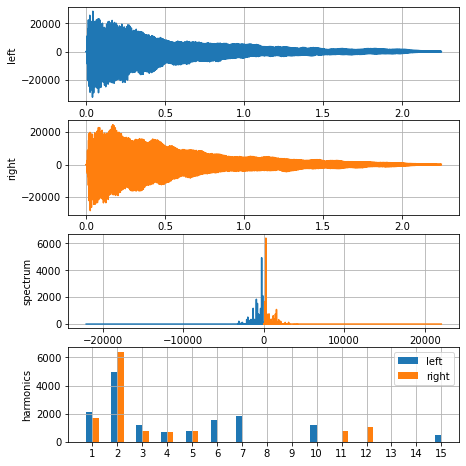

In [18]:
plot_tone_summary(audio_data, sample_rate)
print('c freq:', c_freq / 2)

## Amplitude fit

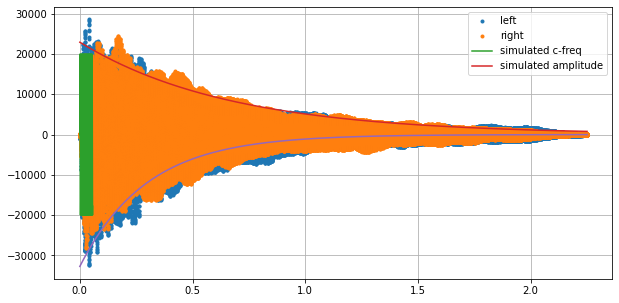

In [19]:
n = audio_data.shape[0]
t = np.arange(n) / sample_rate
plt.plot(t, audio_data[:,0], '.', label='left')
plt.plot(t, audio_data[:,1], '.', label='right')
t1 = np.arange(2500) / sample_rate
c_freq = 261.626
a = 20000
w = a * np.sin(t1*c_freq*2*np.pi)
plt.plot(t1, w, label='simulated c-freq')
plt.plot(t, 0.7 * 2**15 * np.exp(-1.5*t), label='simulated amplitude')
plt.plot(t, - 2**15 * np.exp(-1.5 * 2.25 *t))
#plt.xlim(0, 2500)
plt.legend()

# Wave Generation

In [29]:
class WaveGenerator:
    MAX_AMPL = 2**(8 * SAMPLE_WIDTH - 1) - 1
    def __init__(self, amplitude=lambda x: np.exp(-np.e * x), 
                 sample_rate=44100, 
                 channels=1, 
                 right_offset=np.pi,
                 harmonics=[1.0]
                ):
        assert 1 <= channels <= 2
        assert sample_rate > 0
        self.amplitude = amplitude
        self.channels = channels
        self.sample_rate = sample_rate
        self.right_offset = right_offset
        self.harmonics = np.array(harmonics)
        if len(self.harmonics.shape)==1:
            self.harmonics = self.harmonics.reshape(-1, 1)
        
    def generate(self, freq, duration=1.0):
        left = self.wave(freq, duration, self.harmonics[:,0])
        data = np.empty([len(left), self.channels], dtype=np.int16)
        data[:, 0] = left
        if self.channels==2:
            data[:, 1] = self.wave(freq, duration, 
                                   harmonics=self.harmonics[:,1] if self.harmonics.shape[1]>1 else self.harmonics[:,0], 
                                   offset=self.right_offset)
        return data
    
    def wave(self, freq, duration, harmonics, offset=0.0):
        t = np.arange(int(duration * self.sample_rate) + 1) / self.sample_rate
#         wave = self.MAX_AMPL * self.amplitude(t) * np.sin(2 * np.pi * freq * t + offset)
        wave = np.zeros(len(t))
        for harmonic, amplitude in enumerate(harmonics):
            #print(harmonic, amplitude)
            wave += amplitude * self.sin(t, (harmonic + 1) * freq, offset ) # * np.random.rand())

        wave *= self.amplitude(t)
        wave *= (self.MAX_AMPL-1) / wave.max() #max(wave.max(), -wave.min())
        return wave.round().astype(np.int16)
                
    def sin(self, t, freq, offset):
        return np.sin(2 * np.pi * freq * t + offset)

In [21]:
hleft = spectrum.Spectrum.of(audio_data[:,0], sample_rate).harmonics()
hright = spectrum.Spectrum.of(audio_data[:,1], sample_rate).harmonics()

In [30]:
%%time
hmax = int(max(hleft.factors().max(), hright.factors().max()))
harmonics = np.zeros([hmax, 2])
harmonics[hleft.factors()-1, 0] = hleft.amplitudes
harmonics[hright.factors()-1, 1] = hright.amplitudes
rharmonics = np.random.randn(16, 2)
print(rharmonics)
print(np.diff(sorted(np.abs(rharmonics[:,0]))).min())
generator = WaveGenerator(channels=2, 
                          right_offset=np.pi,
                          amplitude= lambda x: 0.7 * np.exp(-1.5 * x) * (7+np.sin(2*np.pi/0.2*x)), #x / np.exp(4*x),#
                         harmonics= harmonics 
                         )

data = generator.generate(c_freq / 2, duration=2.25)
sa.play_buffer(data, generator.channels, SAMPLE_WIDTH, generator.sample_rate).wait_done()

[[ 1.22834906 -0.29511125]
 [ 1.01427799  1.04061235]
 [-1.31164098 -0.24891445]
 [ 1.95373926  0.8236313 ]
 [-0.39801651 -0.76755288]
 [ 0.63966317  0.02689924]
 [-0.81945701 -0.41331936]
 [-0.07102615 -0.90265232]
 [ 0.8583431  -1.5814307 ]
 [-0.03188779  0.01051947]
 [ 0.72816618  0.69036987]
 [-0.3680572  -1.59690015]
 [-0.28541722  1.64590811]
 [-1.1544584  -0.2671503 ]
 [-0.82714249 -0.5681094 ]
 [-0.76539871  0.95193571]]
0.007685484280912869
Wall time: 2.43 s


In [31]:
sa.play_buffer(audio_data,2,2,sample_rate)

c:/data/music/c.wav
duration: 2.2500226757369615
sample size: 99226
sample rate: 44100
dt: 2.2675736961451248e-05
harmonic base freq: 130.8129197996837 130.83204690788716


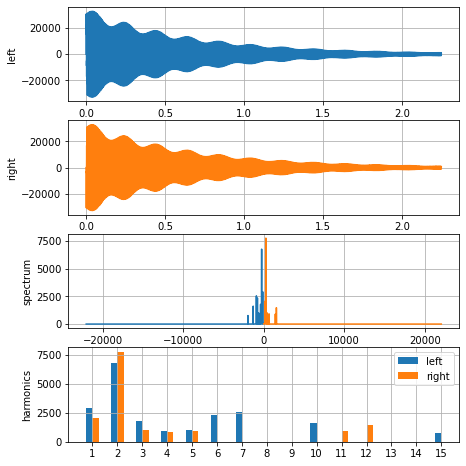

In [32]:
plot_tone_summary(data, sample_rate)